In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline


Bad key text.latex.preview in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
from quetzal.model import stepmodel
from quetzal.io.gtfs_reader import importer
from quetzal.io import excel

# Preparation of the transport network.
## Saves a StepModel with rail service links and nodes from gtfs feeds.

In [3]:
input_path = '../input_static/public_transport/'
output_path = '../input_static/'
model_path = '../model/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [5]:
# Loading StepModel with zones...
sm = stepmodel.read_json(model_path + scenario + '/' + 'de_zones', encoding='latin-1')

In [6]:
# Get the reference geometric hull
sm.zones = gpd.GeoDataFrame(sm.zones)
hull = sm.zones["geometry"].buffer(1e-3).unary_union
hull

In [7]:
# Start with clean links and nodes tables
sm.links = gpd.GeoDataFrame({'geometry' : []})
sm.links.crs = sm.epsg
sm.nodes = gpd.GeoDataFrame({'geometry' : []})
sm.nodes.crs = sm.epsg

In [8]:
# These tables hold side-information
sm.agencies = pd.DataFrame({'agency_id' : []})
sm.pt_routes = pd.DataFrame({'route_id' : []})

## Add public transport gtfs feeds

In [9]:
# Save route types to the model to remember them later
sm.pt_route_types = ['coach', 'rail_long', 'rail_short']

In [10]:
# With this function, we can restrict a feed spatially.
# Drop stops outside a given polygon
def spatial_restrict(feed, polygon):
    # Check geometry
    stops = feed.stops.copy()
    stops['geometry'] = stops.apply(
        lambda r: geometry.Point([r['stop_lon'], r['stop_lat']]), axis=1)
    stops['included'] = stops['geometry'].apply(lambda g: polygon.contains(g))
    
    # Restrict
    feed.stops = feed.stops.loc[stops['included'] == True]
    feed.stop_times = feed.stop_times.loc[
        feed.stop_times['stop_id'].isin(feed.stops['stop_id'])]
    feed.trips = feed.trips.loc[feed.trips['trip_id'].isin(feed.stop_times['trip_id'])]
    return feed

In [11]:
# Generate network graphs for each feed type
for feed_folder in sm.pt_route_types:
    print('Add links and nodes for ' + feed_folder)
    prefix = ''
    prefix = prefix.join([s[0] for s in feed_folder.split('_')]) + '_'
    
    # Load feed
    feed = importer.GtfsImporter(path=input_path + feed_folder + '.zip', dist_units='m')
    feed.stops['parent_station'] = 0
    feed.trips['shape_id'] = 0
    
    # Restrict the feed to a given date in order to analyse a
    # typical work day and not the whole week
    date = str(params['network_preparation']['feed_date_'+feed_folder.split('_')[0]])
    print('Restricted feed to date {}'.format(date))
    feed = feed.restrict(dates=[date])
    
    # Restrict to core hours
    time_range = [t.strip() for t in params['network_preparation']['feed_time_range'].split(',')]
    feed = feed.restrict(time_range=time_range)

    # Give the hourly restricted feed to the spatial restriction
    feed = spatial_restrict(feed, polygon=hull)
    
    # Transform it into a graph
    feed.group_services()
    feed.build_stop_clusters(distance_threshold=params[
        'network_preparation']['cluster_rail_nodes_dist']) # clusterise stops
    feed.build_patterns(on='cluster_id') # use on='stop_id' if you haven't built clusters
    feed_freq = feed.convert_to_frequencies(time_range=time_range)
    
    # Build links and nodes now from the frequency graph
    feed_freq.to_seconds()
    feed_freq.build_links()
    feed_freq.build_geometries(use_utm=False)
    
    # Reindex and set links index to trip_id
    feed_freq.links['trip_id'] = prefix + feed_freq.links['trip_id'].apply(str)
    feed_freq.links.index = [prefix + str(i) for i in range(len(feed_freq.links.index))]

    # Reindex stop_id (with it a and b in links)
    feed_freq.nodes['stop_id'] = prefix + 'n_' + feed_freq.nodes['stop_id'].apply(str)
    feed_freq.links['a'] = prefix + 'n_' + feed_freq.links['a'].apply(str)
    feed_freq.links['b'] = prefix + 'n_' + feed_freq.links['b'].apply(str)
    feed_freq.nodes.set_index('stop_id', drop=True, inplace=True)
    
    # Add route type to links and nodes
    feed_freq.links['route_type'] = feed_folder
    feed_freq.nodes['route_type'] = feed_folder
    
    # Reindex route_id and agency_id
    feed_freq.links['route_id'] = prefix + feed_freq.links['route_id'].apply(str)
    feed_freq.routes['route_id'] = prefix + feed_freq.routes['route_id'].apply(str)
    feed_freq.routes['agency_id'] = prefix + feed_freq.routes['agency_id'].apply(str)
    feed_freq.agency['agency_id'] = prefix + feed_freq.agency['agency_id'].apply(str)
    feed_freq.routes.set_index('route_id', drop=True, inplace=True)
    feed_freq.agency.set_index('agency_id', drop=True, inplace=True)
    
    # Add links and nodes to stepmodel
    sm.links = pd.concat([sm.links, feed_freq.links[
        ['route_id', 'route_type', 'a', 'b', 'time', 'geometry',
         'trip_id', 'link_sequence', 'headway']]])
    sm.nodes = pd.concat([sm.nodes, feed_freq.nodes[
        ['geometry', 'stop_name', 'route_type']]])
    # Add other
    sm.agencies = pd.concat([sm.agencies, feed_freq.agency])
    sm.pt_routes = pd.concat([sm.pt_routes, feed_freq.routes])

Add links and nodes for coach
Restricted feed to date 20170921
Add links and nodes for rail_long
Restricted feed to date 20200211
Add links and nodes for rail_short
Restricted feed to date 20200211


In [12]:
# Fix the network integrity
sm.integrity_fix_nodeset_consistency()
sm.integrity_fix_collision()
sm.integrity_fix_circular_lines()
sm.integrity_fix_sequences()
sm.integrity_fix_nodeset_consistency()

dropped circular lines: ['rs_216_8', 'rs_227_3', 'c_FLIXBUS:320_3', 'rs_257_16', 'c_FLIXBUS:047_4', 'rs_150_8', 'rl_6_57', 'rs_33_385', 'rs_137_8', 'rs_216_405', 'rs_52_82', 'rs_2_51', 'c_FLIXBUS:032_3', 'rs_15_72', 'rs_150_5', 'c_FLIXBUS:042_10', 'rs_265_3', 'rs_174_9', 'rs_93_3', 'rs_33_276', 'c_FLIXBUS:225_5', 'rs_150_9', 'rs_83_9', 'rs_68_2', 'rs_200_34', 'rs_46_14', 'rs_28_24', 'rs_217_1', 'rs_163_4', 'c_FLIXBUS:076_3', 'rs_172_1', 'rs_29_9', 'rs_35_8', 'c_FLIXBUS:244_4', 'rs_215_1', 'rs_280_6', 'c_FLIXBUS:N122_2', 'rs_28_12', 'rs_151_1', 'rs_59_42', 'c_FLIXBUS:320_8', 'rs_302_6', 'rs_257_8', 'rs_200_2', 'c_FLIXBUS:205_8', 'rs_99_5', 'rs_119_27', 'rs_196_4', 'c_FLIXBUS:N207_7', 'c_FLIXBUS:125_9', 'rs_116_329', 'rs_25_49', 'rs_216_230', 'rs_216_78', 'rs_150_7', 'rs_331_6', 'rs_17_71', 'rs_17_219', 'c_FLIXBUS:X50_3', 'c_FLIXBUS:068_8', 'rs_213_3', 'rl_4_57', 'rs_296_4', 'c_FLIXBUS:160_3', 'rs_180_2', 'rs_210_3', 'rs_216_5', 'rs_120_1', 'rs_17_76', 'rs_17_4', 'rs_35_9', 'rs_220_81', 

### Results

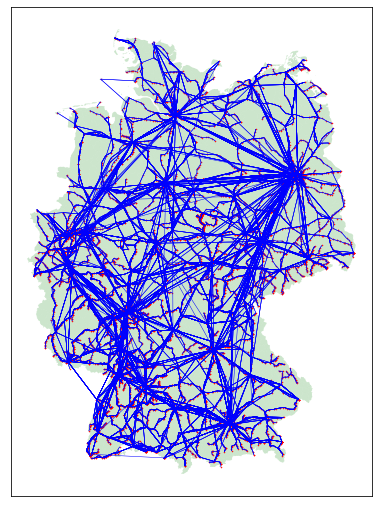

In [13]:
if manual:
    zones_plot = sm.plot('zones', alpha=0.2, figsize=[16, 9], color='green')
    links_plot = sm.plot('links', linewidth=0.5, color='blue', ax=zones_plot)
    plot = sm.plot('nodes', markersize=0.3, color='red', ax=links_plot)
    fig = plot.get_figure()

In [14]:
sm.nodes.sample(3)

geometry           stop_name  route_type
rl_n_1406   POINT (10.77144 48.71403)          Donauwörth   rail_long
rs_n_14063  POINT (13.08188 50.74459)        Zschopau Ost  rail_short
rs_n_10072   POINT (8.66379 50.10714)  Frankfurt(Main)Hbf  rail_short

In [15]:
sm.links.sample(3)

geometry route_id  \
rs_56394  LINESTRING (12.93973 52.55185, 12.50279 52.59991)    rs_74   
rs_27381    LINESTRING (9.49448 50.62693, 9.44726 50.63077)    rs_23   
rs_13147    LINESTRING (8.78554 50.00806, 8.78899 50.01725)    rs_15   

          route_type          a           b   time   trip_id  link_sequence  \
rs_56394  rail_short  rs_n_3809   rs_n_4794  840.0  rs_74_47           16.0   
rs_27381  rail_short  rs_n_8066  rs_n_13237  180.0  rs_23_46            4.0   
rs_13147  rail_short  rs_n_1744   rs_n_1183  120.0   rs_15_8            1.0   

          headway  
rs_56394  43200.0  
rs_27381  43200.0  
rs_13147   1800.0

<AxesSubplot:>

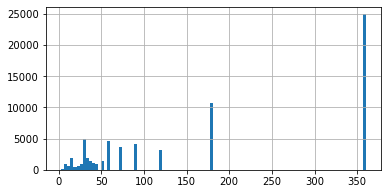

In [16]:
# Waiting time distribution in minutes
(sm.links['headway']/60/2).hist(bins=100, figsize=(6,3), log=False)

In [17]:
sm.agencies.sample()

agency_id                                     agency_name  \
rs_298        NaN  Gesellschaft zur Förderung des ÖPNV Regensburg   

                agency_url agency_timezone agency_lang agency_phone  \
rs_298  http://www.bahn.de   Europe/Berlin         NaN          NaN   

       agency_fare_url agency_email  
rs_298             NaN          NaN

In [18]:
sm.pt_routes.sample()

route_id agency_id route_short_name route_long_name route_desc  \
rs_84       NaN     rs_30             RB36            RB36        NaN   

       route_type route_url route_color route_text_color  
rs_84         2.0       NaN         NaN              NaN

In [19]:
sm.links.shape

(68446, 9)

In [20]:
sm.nodes.shape

(14400, 3)

In [21]:
sm.pt_routes.shape

(543, 9)

In [22]:
len(sm.links['route_id'].unique())

502

## Save model

In [23]:
# Cast columns to int
cols = ['time', 'link_sequence', 'headway']
sm.links[cols] = sm.links[cols].astype(int)

In [24]:
# Saving model...
sm.to_json(output_path + 'de_pt_network',
          only_attributes=['zones', 'links', 'nodes',
                           'agencies', 'pt_routes',
                           'pt_route_types'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 38/38 [00:38<00:00,  1.02s/it]
